In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.models import BlackBody
import astropy.units as u
from scipy.integrate import trapz

c:\Users\shubh\anaconda3\envs\shubh\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\shubh\anaconda3\envs\shubh\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\shubh\anaconda3\envs\shubh\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
B_lambda_units = 1*u.W/u.m**2/u.sr/u.m
def BB_lambda(T : u.K, wavelength_or_frequency) -> u.W/u.m**2/u.sr/u.m:
    BB = BlackBody(temperature=T, scale = B_lambda_units)
    return BB(wavelength_or_frequency)

In [3]:
def parse_csv_file(filename, xunit, yunit):
    data = np.loadtxt(filename, delimiter=',', usecols=(0,1))
    return np.sort(data[:,0]) * xunit, data[:,1][np.argsort(data[:,0])] * yunit

grav_wvs, grav_flux = \
    parse_csv_file("./measurements/betaPic_gravity.csv", u.micron, 1e-15 * u.Unit('W m-2 micron-1'))

In [4]:
jwst_wvs, jwst_flux = \
    parse_csv_file("./measurements/jwst_cont.csv", u.micron, u.Unit('W m-2 micron-1'))

In [5]:
VHS_temp, bPic_temp = 1100*u.K, 1700*u.K

In [6]:
model_grav = BB_lambda(bPic_temp, grav_wvs).to(u.Unit('W m-2 micron-1 sr-1'))
model_jwst = BB_lambda(VHS_temp, jwst_wvs).to(u.Unit('W m-2 micron-1 sr-1'))

In [7]:
for wvs, flux in zip([grav_wvs, jwst_wvs, grav_wvs, jwst_wvs], [grav_flux, jwst_flux, model_grav, model_jwst]):
    flux /= trapz(flux, wvs)

In [8]:
# for flux in [grav_flux, jwst_flux, model_grav, model_jwst]:
#     flux /= np.nanmedian(flux)

In [9]:
# integrate the fluxes
from scipy.integrate import trapz
print("JWST: ", trapz(jwst_flux, jwst_wvs))
print("VHS: ", trapz(model_jwst, jwst_wvs))
print("gravity: ", trapz(grav_flux, grav_wvs))
print("betaPic: ", trapz(model_grav, grav_wvs))

JWST:  1.0
VHS:  1.0
gravity:  0.9999999999999998
betaPic:  1.0


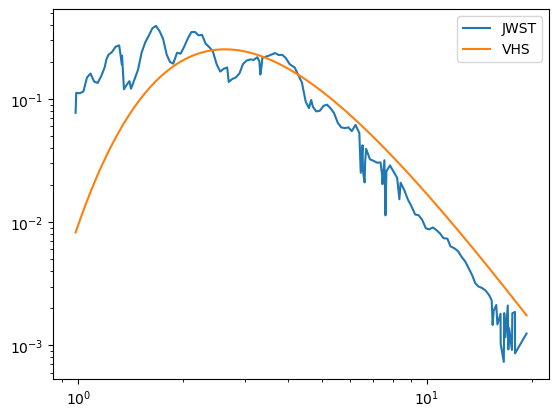

In [10]:
plt.figure()
plt.plot(jwst_wvs, jwst_flux, label='JWST')
plt.plot(jwst_wvs, model_jwst, label='VHS')
plt.loglog()
plt.legend()
plt.show()
plt.close()

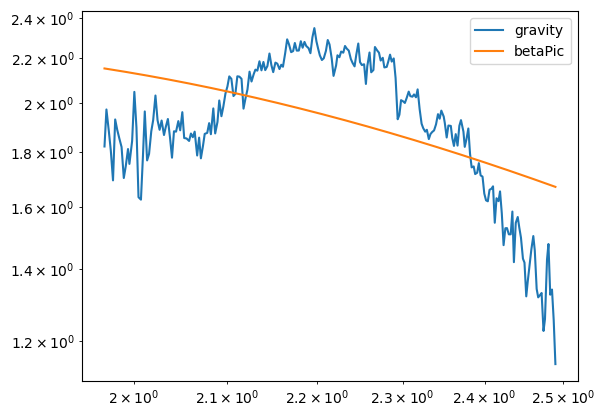

In [11]:
plt.figure()
plt.plot(grav_wvs, grav_flux, label='gravity')
plt.plot(grav_wvs, model_grav, label='betaPic')
plt.loglog()
plt.legend()
plt.show()
plt.close()

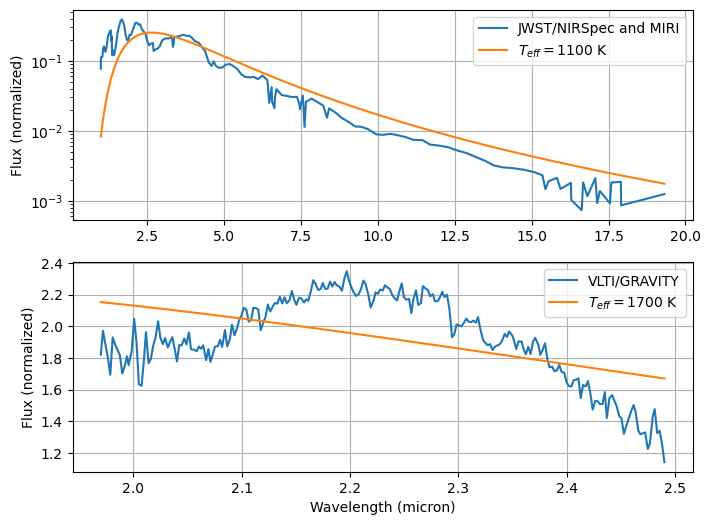

In [12]:
# two subplots top and bottom 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.plot(jwst_wvs, jwst_flux, label='JWST/NIRSpec and MIRI')
ax1.plot(jwst_wvs, model_jwst, label=r'$T_{eff} = 1100$ K')
ax1.set_yscale('log')
ax1.legend()
ax1.grid()
ax1.set_ylabel('Flux (normalized)')
ax2.plot(grav_wvs, grav_flux, label='VLTI/GRAVITY')
ax2.plot(grav_wvs, model_grav, label=r'$T_{eff} = 1700$ K')
# ax2.set_yscale('log')
ax2.set_ylabel('Flux (normalized)')
ax2.legend()
ax2.grid()
ax2.set_xlabel('Wavelength (micron)')
plt.savefig('./plots/continuum.png', dpi=300)
plt.show()

In [13]:
def get_filename_from_pars(Teff, logg, root_dir="./bt-settl/models_1671388423/bt-settl/"):
    """
    Get the filename for the BT-Settl model with the given effective temperature and surface gravity.
    Assume metallicity to be zero.
    root_dir is the path to the directory containing the BT-Settl models.
    """
    # The BT-Settl filenames are of the form "lte{teff:05d}-{logg:4.2f}.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits"
    # where the effective temperature is in Kelvin and the surface gravity is in log10(cm/s^2).
    # The surface gravity is rounded to the nearest 0.5.
    return root_dir + \
        "lte0{:1d}-{:3.1f}-0.0.BT-Settl.7.dat.txt".format(int(np.round(Teff/100)), np.round(logg, 1))

get_filename_from_pars(1000, 4.5)

'./bt-settl/models_1671388423/bt-settl/lte010-4.5-0.0.BT-Settl.7.dat.txt'

In [14]:
# parse data file with two columns
# ignorning lines starting with #
# and return result as two numpy arrays
def parse_data_file(filename):
    data = np.loadtxt(filename, comments='#')
    return data[:,0] * u.Angstrom, data[:,1] * u.Unit('erg cm-2 s-1 Angstrom-1')

parse_data_file(get_filename_from_pars(1000, 4.5))

(<Quantity [0.00000e+00, 1.00000e-03, 2.00000e-03, ..., 9.98227e+06,
            9.98727e+06, 9.99227e+06] Angstrom>,
 <Quantity [2.11349e-97, 2.11349e-97, 2.11349e-97, ..., 2.22844e-06,
            2.45132e-06, 2.63330e-06] erg / (Angstrom cm2 s)>)

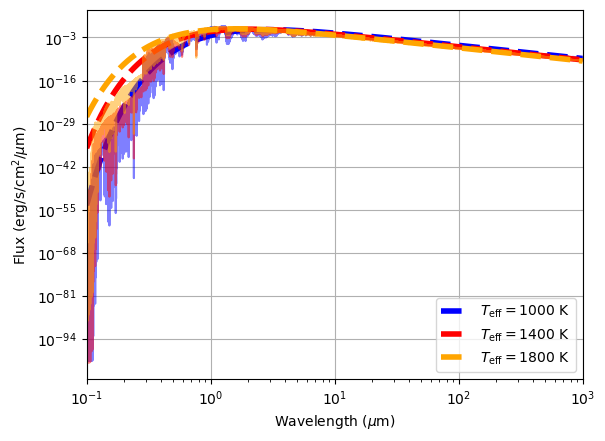

In [15]:
# plot the data from parse_data_file
plt.figure()
low_wv, upp_wv = 1e-1 * u.micron, 1e3 * u.micron
plt.xlim([low_wv.to('micron').value, upp_wv.to('micron').value])
for temperature, color in zip([1000*u.K, 1400*u.K, 1800*u.K], ["blue", "red", "orange"]):
    wvs, flux = parse_data_file(get_filename_from_pars(temperature.to(u.K).value, 4.5))
    wvs, flux = wvs.to("micron"), flux.to("erg/s/cm^2/micron")
    wvs, flux = wvs[low_wv < wvs], flux[low_wv < wvs]
    wvs, flux = wvs[wvs < upp_wv], flux[wvs < upp_wv]
    model_Planck = BB_lambda(temperature, wvs).to(u.Unit('W m-2 micron-1 sr-1'))
    model_Planck /= trapz(model_Planck, wvs)
    flux /= trapz(flux, wvs)
    plt.plot(wvs, flux, color = color, alpha=0.5)
    plt.plot(wvs, model_Planck, color = color, linestyle = "--", linewidth = 4, \
        label = r"$T_\mathrm{} = {:d}$ K".format("{eff}", int(temperature.to(u.K).value)))
plt.xlabel(r"Wavelength ($\mu$m)")
plt.ylabel(r"Flux (erg/s/cm$^2$/$\mu$m)")
plt.legend()
plt.loglog()
plt.grid()
plt.savefig('./plots/bt-settl_cont.png', dpi=300)
plt.show() 
plt.close()